In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest
import pickle
import scipy.sparse as sparse
from implicit.als import AlternatingLeastSquares 

d:\recommend\Recommendation_Systems\RS_virt\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Exploratory Data Analysis

In [2]:


# Load raw CSV files
events_df = pd.read_csv("events.csv")
item_properties_1 = pd.read_csv("item_properties_part1.1.csv")
item_properties_2 = pd.read_csv("item_properties_part2.csv")
category_tree = pd.read_csv("category_tree.csv")

# Merge item properties (since it's split into two parts)
item_properties = pd.concat([item_properties_1, item_properties_2])

# Display basic info
print("Events Dataset Info:")
events_df.info()
print("\nItem Properties Dataset Info:")
item_properties.info()
print("\nCategory Tree Dataset Info:")
category_tree.info()


Events Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 105.1+ MB

Item Properties Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 20275902 entries, 0 to 9275902
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   timestamp  int64 
 1   itemid     int64 
 2   property   object
 3   value      object
dtypes: int64(2), object(2)
memory usage: 773.5+ MB

Category Tree Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   categoryid  1669 non-null   int64  
 1   parentid    164

In [3]:
# Check missing values in all datasets
print("Missing Values in Events Dataset:")
print(events_df.isnull().sum())

print("\nMissing Values in Item Properties Dataset:")
print(item_properties.isnull().sum())

print("\nMissing Values in Category Tree Dataset:")
print(category_tree.isnull().sum())


Missing Values in Events Dataset:
timestamp              0
visitorid              0
event                  0
itemid                 0
transactionid    2733644
dtype: int64

Missing Values in Item Properties Dataset:
timestamp    0
itemid       0
property     0
value        0
dtype: int64

Missing Values in Category Tree Dataset:
categoryid     0
parentid      25
dtype: int64


Summary Statistics

In [5]:
# Summary statistics for numerical columns
print(events_df.describe())



          timestamp     visitorid        itemid  transactionid
count  2.756101e+06  2.756101e+06  2.756101e+06   22457.000000
mean   1.436424e+12  7.019229e+05  2.349225e+05    8826.497796
std    3.366312e+09  4.056875e+05  1.341954e+05    5098.996290
min    1.430622e+12  0.000000e+00  3.000000e+00       0.000000
25%    1.433478e+12  3.505660e+05  1.181200e+05    4411.000000
50%    1.436453e+12  7.020600e+05  2.360670e+05    8813.000000
75%    1.439225e+12  1.053437e+06  3.507150e+05   13224.000000
max    1.442545e+12  1.407579e+06  4.668670e+05   17671.000000


In [6]:
# If item properties contain numeric values:
print(item_properties.describe())


          timestamp        itemid
count  2.027590e+07  2.027590e+07
mean   1.435157e+12  2.333904e+05
std    3.327798e+09  1.348452e+05
min    1.431227e+12  0.000000e+00
25%    1.432436e+12  1.165160e+05
50%    1.433646e+12  2.334830e+05
75%    1.437880e+12  3.503040e+05
max    1.442113e+12  4.668660e+05


#### Univariate Analysis

Distribution of Numerical Columns

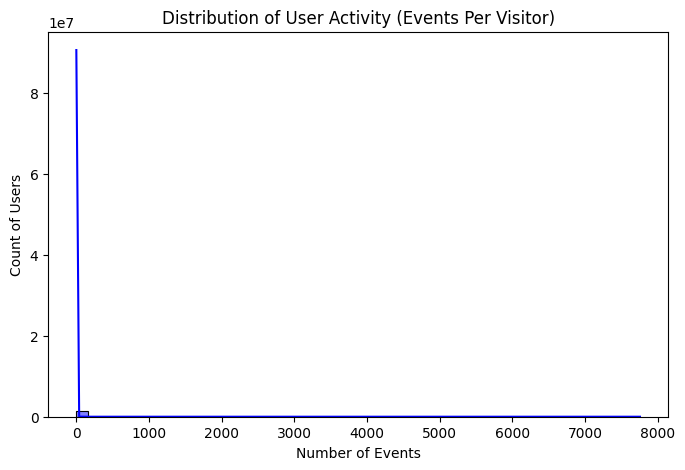

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert timestamp to datetime
events_df['datetime'] = pd.to_datetime(events_df['timestamp'], unit='ms')

# Plot distribution of visitor activity
plt.figure(figsize=(8, 5))
sns.histplot(events_df['visitorid'].value_counts(), bins=50, kde=True, color="blue")
plt.title("Distribution of User Activity (Events Per Visitor)")
plt.xlabel("Number of Events")
plt.ylabel("Count of Users")
plt.show()


Detecting Outliers in Number of Events Per User

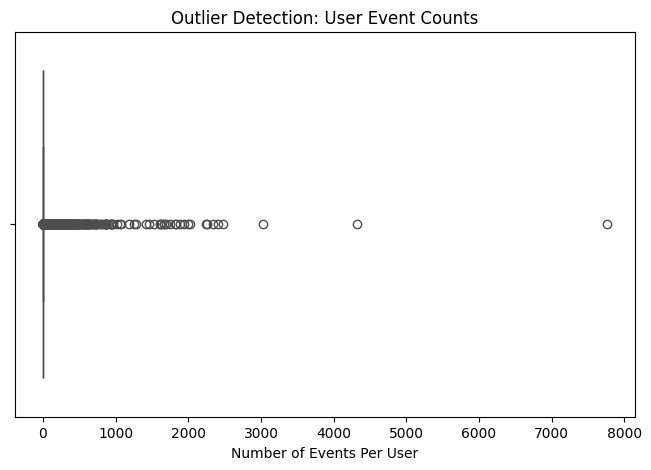

In [8]:
# Boxplot to detect extreme users
plt.figure(figsize=(8, 5))
sns.boxplot(x=events_df['visitorid'].value_counts(), color="red")
plt.title("Outlier Detection: User Event Counts")
plt.xlabel("Number of Events Per User")
plt.show()
